Recession pop is a term used in the internet to describe a specific genre of chart-topping music that tends to emerge during times of economic distress, directly inspired by the pop hits released during the 2008 recession in the United States. I was curious to explore whether popular music reflects the the health of an economy. 

This project evaluates the relationship between music and the state of the economy of United States between 1960 to 2025

It attempts to ask questions like: Does music sound different when the economy is triving? Is popular music a reflection of the economy? 
                                     ***What are the songs of the economy?***

This project will be a combination of data cleaning, explanatory data analysis and machine learning using linear regression and time series analysis.

By the end of this project, I hope to determine whether 'recession pop' is an actual phenomena.




In [ ]:
import pandas as pd             
import numpy as np              
import matplotlib.pyplot as plt 
import seaborn as sns            
from sklearn.model_selection import train_test_split  #Splitting data
from sklearn.linear_model import LinearRegression      #Linear regression model
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn import preprocessing #Normalizing


The first dataset contains the GDP and Unemployment rate between 1950s to 2024. There are many irrelevent data. This section cleans the dataset and extracts relevant information into a new dataset I can work with.


I am using GDP growth and unemployment rate as the indicators of the economy. Given their differing scales, I have normalized them to ensure even distribution accross variables. 

In [19]:
economics_data = pd.read_csv('data_files/socioeconomic_context_Data.csv')

#Extracting relevent information
economics_data = economics_data.iloc[[1,5],].reset_index(drop=True)
economics_data.drop(list(economics_data.columns)[0:2], axis=1, inplace=True)
economics_data.drop(list(economics_data.columns)[1:3], axis=1, inplace=True)
economics_data.drop(list(economics_data.columns)[-1:], axis=1, inplace=True)


#Normalizing the main variables 
GDP_growth = np.array(economics_data.iloc[0][1:])
normalized_GDP_growth = preprocessing.normalize([GDP_growth]).tolist()[0]

unexployment_rate = np.array(economics_data.iloc[1][1:])
normalized_unemployment_rate = preprocessing.normalize([unexployment_rate]).tolist()[0]

#Creating a new dataframe with relevant information
economic_score = []
year = []
for index in range(len(normalized_GDP_growth)):
    score = normalized_GDP_growth[index] - normalized_unemployment_rate[index]
    economic_score.append(score)
    year.append(1961+index)

economics_df = pd.DataFrame({
    'year': year,
    'economic_score' : economic_score
})




The second dataset contains popular songs of every decade from the 1960s to 2010s. This section combines all the musical data avaible and extracts relevant information. 

In [ ]:
music_60s = pd.read_csv('data_files/1960.csv')
music_70s = pd.read_csv('data_files/1970.csv')
music_80s = pd.read_csv('data_files/1980.csv')
music_90s = pd.read_csv('data_files/1990.csv')
music_00s = pd.read_csv('data_files/2000.csv')
music_10s = pd.read_csv('data_files/2010.csv')

music_df = pd.concat([music_60s, music_70s,music_80s,music_90s, music_00s, music_10s], ignore_index=True, axis=0)
music_df= music_df.sort_values('year')

#Only keeping the relevant information
music_df.drop(list(music_df.columns)[0:4], axis=1, inplace=True) 

#Renaming all the columns to make it more readable
music_df.rename(columns={
    'bpm': 'bpm',
    'nrgy': 'energy_level',
    'dnce': 'danceability',
    'dB': 'dB',
    'live': 'liveness',
    'val': 'valence',
    'dur': 'duration',
    'acous': 'acousticness',
    'spch': 'speechiness',
    'pop': 'popularity'
}, inplace=True)




Combining all the datasets together into one. Aggregating by year helps reduce the noise in the data

In [77]:
df = economics_df.merge(music_df, on = 'year')
df = df.groupby(df.year).mean([list(df.columns)])



Now that we have a dataframe with all the relevant information, lets look at how each feature changes over time and whether the changes in the economic score is similar to the changes of each song feature. 

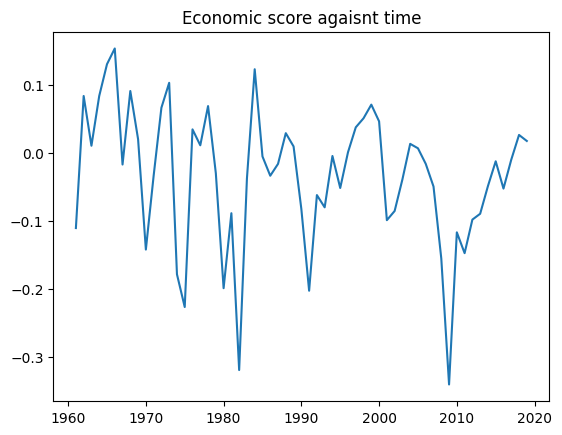

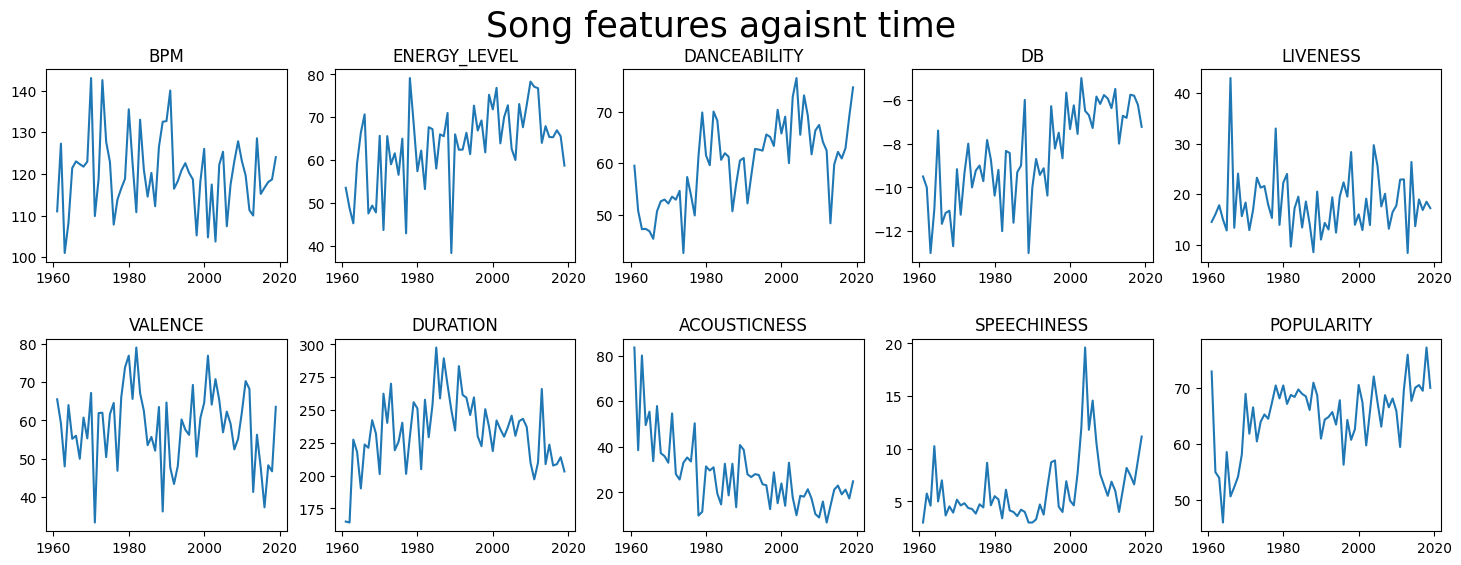

In [75]:
x_axis = [i for i in range(1961,2020)]

plt.plot(x_axis,df.economic_score)
plt.title('Economic score agaisnt time')
plt.show()
plt.close()


plt.subplots(2,5,figsize=(18,6))
plt.suptitle('Song features agaisnt time',size=25)
titles = df.columns
for i in range(1,11,1):
    plt.subplot(2,5,i)
    plt.plot(x_axis,df[titles[i]])
    plt.title(titles[i].upper())
plt.subplots_adjust(hspace=0.4)


From the plots, popular songs have become louder, more energetic, more danceable, less acoustic, and shorter in duration. Some features like valence and popularity have generally increased, while others like liveness and speechiness show occasional spikes but no strong trend.


Seeing how many song qualities have changed over time, how many of these changes have been influenced by the economic conditions? 
Lets look at how these qualities relate to the economic score.

According to the coreelation coefficients, the song features that correlates with economic_score the strongest are: 
liveness with correlation coefficient of 0.25
speechiness with correlation coefficient of 0.15
danceability with correlation coefficient of -0.18
popularity with correlation coefficient of -0.31


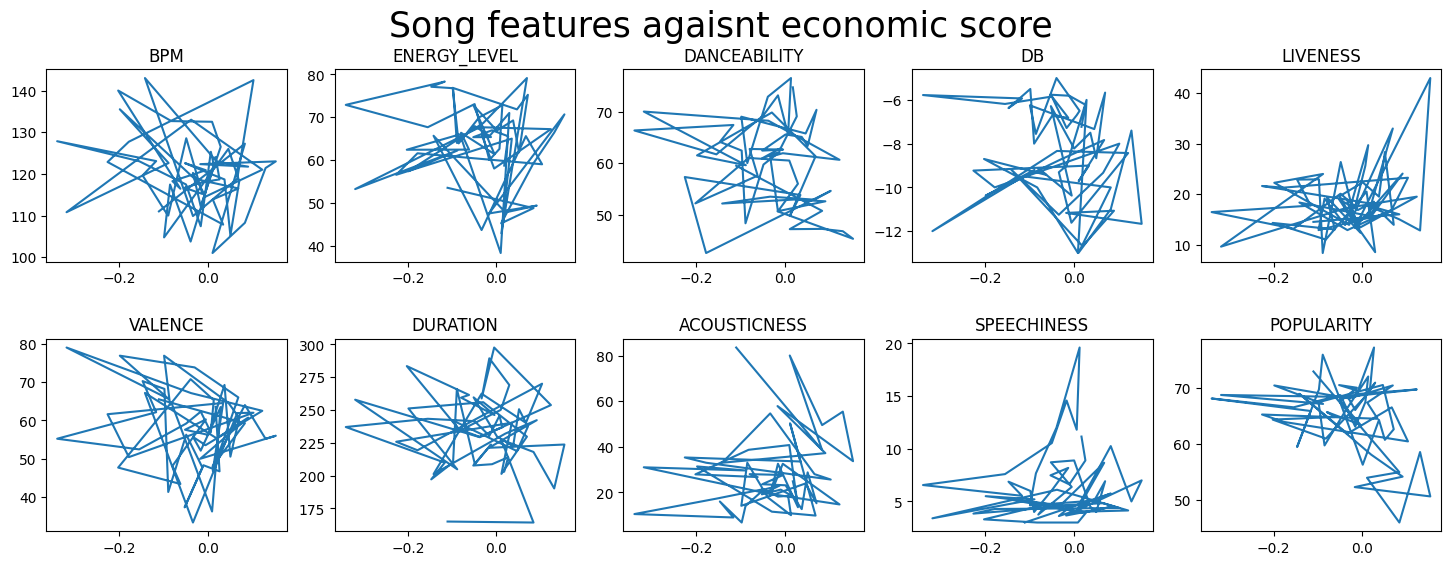

In [100]:
x_axis = df.economic_score


plt.subplots(2,5,figsize=(18,6))
plt.suptitle('Song features agaisnt economic score',size=25)
titles = df.columns
for i in range(1,11,1):
    plt.subplot(2,5,i)
    plt.plot(x_axis,df[titles[i]])
    plt.title(titles[i].upper())
plt.subplots_adjust(hspace=0.4)

correlations = df.corr(numeric_only=True)['economic_score'].sort_values(ascending=False).reset_index()


correlations.rename(columns={
'economic_score': 'correlation'
}, inplace=True)

print('According to the coreelation coefficients, the song features that correlates with economic_score the strongest are: ')
features = []
for idx,row in correlations.iterrows():
    
    if abs(row['correlation']) > 0.14 and row['correlation']<1:
        print(f"{row['index']} with correlation coefficient of {round(row['correlation'],2)}")
        features.append(row['index'])







Linear Regression Performance:
R² score: 0.275
RMSE: 0.085
Feature Coefficients:
        Feature  Coefficient
0      liveness     0.001431
1   speechiness     0.009529
2  danceability    -0.003746
3    popularity    -0.003383


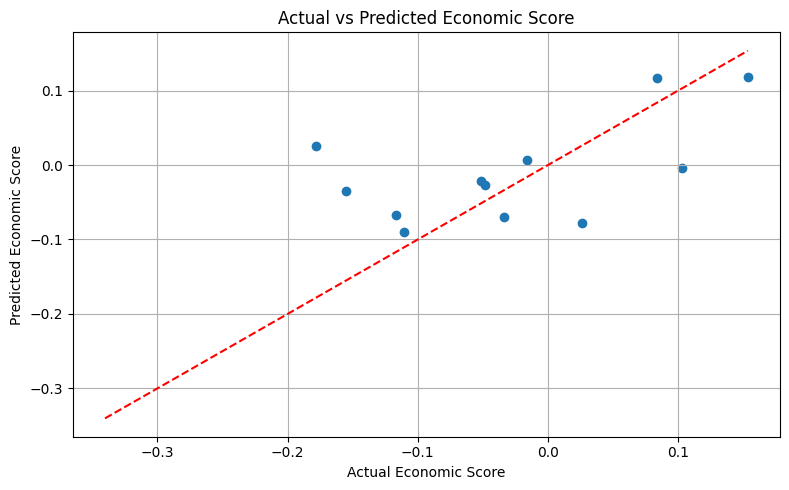

In [102]:


X = df[features]
y = df['economic_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LinearRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


print("Linear Regression Performance:")
print(f"R² score: {r2_score(y_test, y_pred):.3f}")
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.3f}")


coefficients = pd.DataFrame({'Feature': features, 'Coefficient': model.coef_})
print("Feature Coefficients:")
print(coefficients)


plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual Economic Score')
plt.ylabel('Predicted Economic Score')
plt.title('Actual vs Predicted Economic Score')
plt.grid(True)
plt.tight_layout()
plt.show()



Time Series Linear Regression Performance:
R² score: -0.171
RMSE: 0.104
Time-Lagged Feature Coefficients:
            Feature  Coefficient
0  econ_score_lag1     0.276981
1         pop_lag1    -0.001300
2        dnce_lag1    -0.001673
3        spch_lag1     0.006383
4        live_lag1    -0.003775


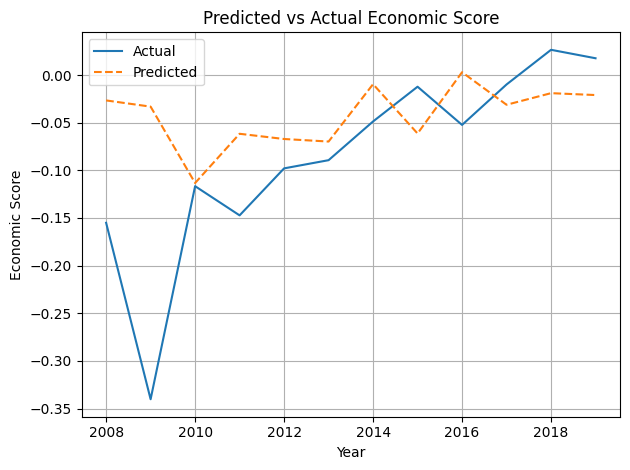

In [107]:

df['econ_score_lag1'] = df['economic_score'].shift(1)
df['pop_lag1'] = df['popularity'].shift(1)
df['dnce_lag1'] = df['danceability'].shift(1)
df['spch_lag1'] = df['speechiness'].shift(1)
df['live_lag1'] = df['liveness'].shift(1)

df_ts = df.dropna().copy()


X_ts = df_ts[['econ_score_lag1', 'pop_lag1', 'dnce_lag1', 'spch_lag1', 'live_lag1']]
y_ts = df_ts['economic_score']


split_index = int(len(df_ts) * 0.8)
X_train_ts, X_test_ts = X_ts.iloc[:split_index], X_ts.iloc[split_index:]
y_train_ts, y_test_ts = y_ts.iloc[:split_index], y_ts.iloc[split_index:]


ts_model = LinearRegression()
ts_model.fit(X_train_ts, y_train_ts)
y_pred_ts = ts_model.predict(X_test_ts)




print("\nTime Series Linear Regression Performance:")
print(f"R² score: {r2_score(y_test_ts, y_pred_ts):.3f}")
rmse_ts = np.sqrt(mean_squared_error(y_test_ts, y_pred_ts))
print(f"RMSE: {rmse_ts:.3f}")


ts_coefs = pd.DataFrame({
    'Feature': X_ts.columns,
    'Coefficient': ts_model.coef_
})
print(f"Time-Lagged Feature Coefficients:\n {ts_coefs}")

plt.plot(y_test_ts.index, y_test_ts, label='Actual')
plt.plot(y_test_ts.index, y_pred_ts, label='Predicted', linestyle='--')
plt.title("Predicted vs Actual Economic Score")
plt.xlabel("Year")
plt.ylabel("Economic Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
